<img style="float: left;" src="http://sindser.org.br/s/wp-content/uploads/2013/09/iesb1.jpg"  width="400" height="400">

## Instituto de Educação Superior de Brasília
## Pós Graduação em Ciência de Dados
## Data Mining e Machine Learning II
## Leandro Alencar – 1931133007

----
# Modelos de Classificação por Árvore de Decisão
## Table of contents
* [Introdução](#introducao)
* [Dados](#data)
* [Análises Descritivas](#analises)
* [Modelo](#model)
* [Conclusão](#conclusao)

# 1. Introdução <a name="introducao"></a>
Este trabalho consiste na análise da base de dados HMEQ (Home Equity), que é composta por informações de quase 6 mil operações de crédito, e desenvolvimento de um modelo que será capaz de indicar se um indivíduo irá honrar o compromisso até o final ou não, de forma a subsidiar a tomada de decisão no processo de aprovação de linha de crédito para um novo cliente de uma entidade financeira ou afim. Os modelos baseados em árvore de decisão escolhidos são: 
> Random Forest Classifier  
Extra Trees Classifier

# 2. Dados <a name="data"></a>
A base de dados está disponível em https://www.kaggle.com/ajay1735/hmeq-data, e contém 5.960 regitros de empréstimos com apenas 13 categorias de dados, sendo elas:

* BAD : se o cliente faltou com o pagamento do empréstimo (1 = Sim)
* LOAN : Valor solicitado de empréstimo
* MORTDUE : Amount due on existing mortgage
* VALUE : Valor atual da propriedade
* REASON : Razão da solicitação (DebtCon: consolidação de débitos | HomeImp: melhoria na casa)
* JOB : Seis categoria ocupacionais
* YOJ : Tempo no trabalho atual em anos
* DEROG : Quantidade de principais relatórios depreciativos
* DELINQ : Quantidade de linhas de crédito inadimplentes
* CLAGE : Idade da linha de negociaação mais antiga em meses
* NINQ : Quantidade de linhas de crédito recentes
* CLNO : Quantidade de linhas de crédito
* DEBTINC : razão débito sobre receita 
----


### 2.1 Bibliotecas e dependências do Python:
* Pandas – Manipulação e análise de dados 
* Matplotlib – Visualização gráfica
* Seaborn - Visualização gráfica         
* Scikit-learn - Aprendizado de máquina

In [1]:
import pandas as pd
pd.options.display.max_columns = 200
pd.options.display.max_rows = 100
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import seaborn as sns
from sklearn.utils import resample
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
import  warnings
warnings.filterwarnings("ignore")

# 3. Análises Exploratórias<a name="analises"></a>
Primeiro realizou-se a visualização rápida das principais informações (missings, formato de dados e balanceamento) para levantamento das estratégias de preprocessamento. As colunas foram importadas corretamente quanto ao seu formato, porém foi verificada uma grande quantidade de missings, inclusive registros com apenas 1 valor preenchido e desbalanceamento das classes da variável resposta "BAD".

Essas inconsistências serao tratadas em etapa posterior.



In [2]:
file = '/kaggle/input/hmeq-data/hmeq.csv'
df = pd.read_csv(file)
# Visualização de informações gerais e missings
df.info()

# Visualização da distribuição de classes
print('\nDistribuição da Categoria BAD:\n', df['BAD'].value_counts(normalize=True))

# Visualização das 5 primeiras linhas do dataset
df.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5960 entries, 0 to 5959
Data columns (total 13 columns):
BAD        5960 non-null int64
LOAN       5960 non-null int64
MORTDUE    5442 non-null float64
VALUE      5848 non-null float64
REASON     5708 non-null object
JOB        5681 non-null object
YOJ        5445 non-null float64
DEROG      5252 non-null float64
DELINQ     5380 non-null float64
CLAGE      5652 non-null float64
NINQ       5450 non-null float64
CLNO       5738 non-null float64
DEBTINC    4693 non-null float64
dtypes: float64(9), int64(2), object(2)
memory usage: 605.4+ KB

Distribuição da Categoria BAD:
 0    0.800503
1    0.199497
Name: BAD, dtype: float64


,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,1,1100,25860.0,39025.0,HomeImp,Other,10.5,0.0,0.0,94.366667,1.0,9.0,NaN
1,1,1300,70053.0,68400.0,HomeImp,Other,7.0,0.0,2.0,121.833333,0.0,14.0,NaN
2,1,1500,13500.0,16700.0,HomeImp,Other,4.0,0.0,0.0,149.466667,1.0,10.0,NaN
3,1,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,1700,97800.0,112000.0,HomeImp,Office,3.0,0.0,0.0,93.333333,0.0,14.0,NaN


### 3.1 Visualização Gráfica
A fim de verificar presença de viés, optou-se pela ilustração gráfica das variáveis numéricas e categórias distribuídas pela variável resposta, "BAD", e ficou demonstrado que no caso das numéricas, e com exceção de "DEROG" e "DELINQ", estão bem distribuídas. 

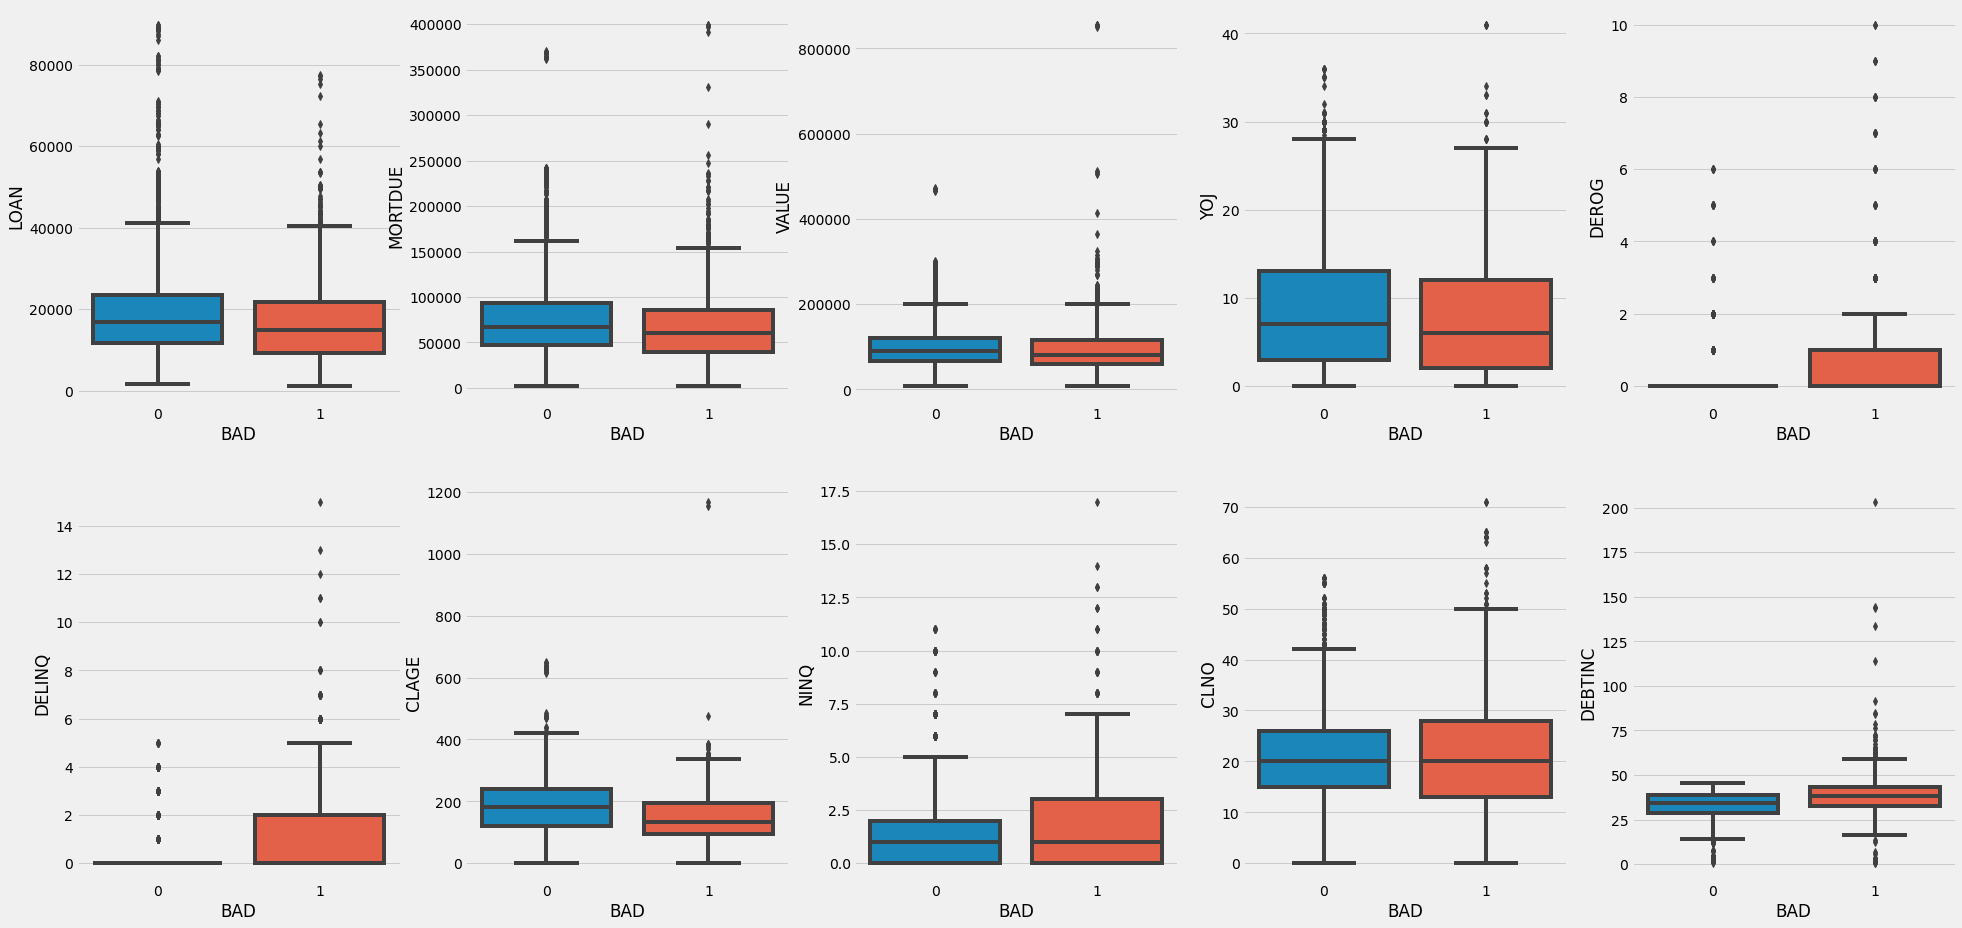

In [3]:
fig, ax = plt.subplots(2,5, figsize=(30,15))
row_1 = ['LOAN','MORTDUE','VALUE','YOJ','DEROG']
row_2 = ['DELINQ','CLAGE','NINQ','CLNO','DEBTINC']
row_3 = []
for i, col in enumerate(row_1):
    sns.boxplot(x=df['BAD'], y=df[col], ax=ax[0,i])
for i, col in enumerate(row_2):
    sns.boxplot(x=df['BAD'], y=df[col], ax=ax[1,i])

No caso da variável categórica "REASON", para cada classe existente a distribuição entre "BAD = 1" e "BAD = 0" é semelhante, em torno de 20% das observações são do tipo que não honram com o pagamento do empréstimo.

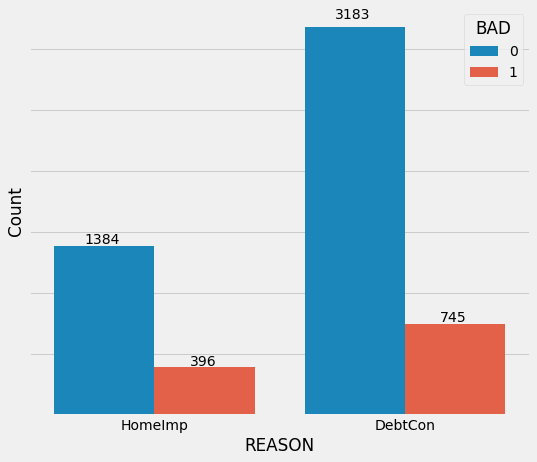

In [4]:
fig, ax = plt.subplots(figsize=(8,7))
ax = sns.barplot(x="REASON", y="BAD", hue='BAD', data=df, estimator=lambda x: len(x))
ax.annotate(df['REASON'][(df['REASON'] == 'HomeImp') & (df['BAD'] == 0)].shape[0], xy=(0.11, 0.42), xycoords="axes fraction")
ax.annotate(df['REASON'][(df['REASON'] == 'HomeImp') & (df['BAD'] == 1)].shape[0], xy=(0.32, 0.12), xycoords="axes fraction")
ax.annotate(df['REASON'][(df['REASON'] == 'DebtCon') & (df['BAD'] == 0)].shape[0], xy=(0.61, 0.97), xycoords="axes fraction")
ax.annotate(df['REASON'][(df['REASON'] == 'DebtCon') & (df['BAD'] == 1)].shape[0], xy=(0.82, 0.23), xycoords="axes fraction")
plt.ylabel('Count')
plt.tick_params(
    axis='y',          
    left=False,
    labelleft=False)

### 3.2 Valores missing
A primeira estratégia adotada foi de eliminar as linhas que apresentavam mais da metade das colunas com campo missing, uma vez que esses registros não correponderiam à verdade caso realizássemos a introdução de novos valores baseado em medidas de agrupamento (média, moda, etc). Esse passo resultou na redução de 126 linhas. 

Posteriormente o tipo de tratamento foi realizado com base nos dois tipos de dados: substituição dos missings pela moda, para os categóricos; preencimento dos missings por "-1", para os numéricos. A moda foi escolhida por uma questão estatística, imaginando que por se refletir um comportamento da sociedade, seria mais provavel que aquele indivíduo sem informação pertencesse ao grupo de maior predominância, e também não resultaria em um enviesamento dos dados, pois a quantidade desses registros nulos era bem pequena. Para os dados numéricos, o método foi pensado tendo em mente o algorítimo escolhido para solucionar o problema, um algorítimo de arvore de decisão. Optou-se, então, pelo preenchimento por um valor que não influenciasse o resultado deste algorítmo, por isso a escolha do "-1".


In [5]:
df = df.dropna(thresh=df.shape[1]/2, axis=0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5834 entries, 0 to 5959
Data columns (total 13 columns):
BAD        5834 non-null int64
LOAN       5834 non-null int64
MORTDUE    5393 non-null float64
VALUE      5739 non-null float64
REASON     5667 non-null object
JOB        5660 non-null object
YOJ        5426 non-null float64
DEROG      5252 non-null float64
DELINQ     5380 non-null float64
CLAGE      5652 non-null float64
NINQ       5450 non-null float64
CLNO       5738 non-null float64
DEBTINC    4606 non-null float64
dtypes: float64(9), int64(2), object(2)
memory usage: 638.1+ KB


In [6]:
# =============================================================================
# Tratando colunas categóricas
# =============================================================================
for col in df.select_dtypes(include='object').columns:
    if df[col].isna().sum() > 0:
         df[col].fillna(df[col].mode()[0], inplace=True)   

In [7]:
# =============================================================================
# Tratando colunas numéricas
# =============================================================================
for col in df.select_dtypes(exclude='object').columns:
    if df[col].isna().sum() > 0:
        df[col].fillna(-1, inplace=True)      

In [8]:
# =============================================================================
# Resultado
# =============================================================================
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5834 entries, 0 to 5959
Data columns (total 13 columns):
BAD        5834 non-null int64
LOAN       5834 non-null int64
MORTDUE    5834 non-null float64
VALUE      5834 non-null float64
REASON     5834 non-null object
JOB        5834 non-null object
YOJ        5834 non-null float64
DEROG      5834 non-null float64
DELINQ     5834 non-null float64
CLAGE      5834 non-null float64
NINQ       5834 non-null float64
CLNO       5834 non-null float64
DEBTINC    5834 non-null float64
dtypes: float64(9), int64(2), object(2)
memory usage: 638.1+ KB


### 3.3 Balanceamento de Classes
O balanceamento de classes é extremamente importante para a precisão do nosso modelo, e para o método escolhido foi o de "upsampling" da classe de menor frequência por meio de uma função do pacote Scikit-Learn.

Abaixo uma função que irá mostrar a distribuição das classes em todas as variáveis categóricas, mas só iremos balancear a variável resposta, "BAD".

In [9]:
def showBalance(df, col):
    for c in col:
        print('Distribuição da Coluna: ', c,'\n',df[c].value_counts(normalize=True),'\n')
    else:
       pass
        
showBalance(df, col=['REASON','JOB','BAD'])

Distribuição da Coluna:  REASON 
 DebtCon    0.69952
HomeImp    0.30048
Name: REASON, dtype: float64 

Distribuição da Coluna:  JOB 
 Other      0.436750
ProfExe    0.218375
Office     0.161981
Mgr        0.131128
Self       0.033082
Sales      0.018684
Name: JOB, dtype: float64 

Distribuição da Coluna:  BAD 
 0    0.800994
1    0.199006
Name: BAD, dtype: float64 



In [10]:
# =============================================================================
# Função para realizar balanceamento
# =============================================================================
def balance(df, col):
    df_maior = df[df[col] == df[col].mode()[0]]
    df_menor = df[df[col] != df[col].mode()[0]]
 
    # Upsample da menor classe
    df_menor_upsampled = resample(df_menor, 
                                  replace=True,     
                                  n_samples=df_maior.shape[0],
                                  random_state=42) 
 
    # Combinar as classe predominante com a menor classe aumentada
    df_upsample = pd.concat([df_maior, df_menor_upsampled])

    # Display new class counts
    print('Contagem de registros')
    print(df_upsample['BAD'].value_counts())
    print('\nDistribuição dos registros')
    print(df_upsample['BAD'].value_counts(normalize=True))

    return df_upsample
    
df_upsample = balance(df, 'BAD')
print('\n')
showBalance(df_upsample, col=['REASON','JOB','BAD'])

Contagem de registros
1    4673
0    4673
Name: BAD, dtype: int64

Distribuição dos registros
1    0.5
0    0.5
Name: BAD, dtype: float64


Distribuição da Coluna:  REASON 
 DebtCon    0.688423
HomeImp    0.311577
Name: REASON, dtype: float64 

Distribuição da Coluna:  JOB 
 Other      0.450139
ProfExe    0.207468
Mgr        0.143698
Office     0.134710
Self       0.041515
Sales      0.022470
Name: JOB, dtype: float64 

Distribuição da Coluna:  BAD 
 1    0.5
0    0.5
Name: BAD, dtype: float64 



#### Visualização da distribuição de frequência
Abaixo podemos ver como ficou a distribuição de frequência de todas as variáveis após o processo de tratamento de dados.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff3d292f358>,
      dtype=object)

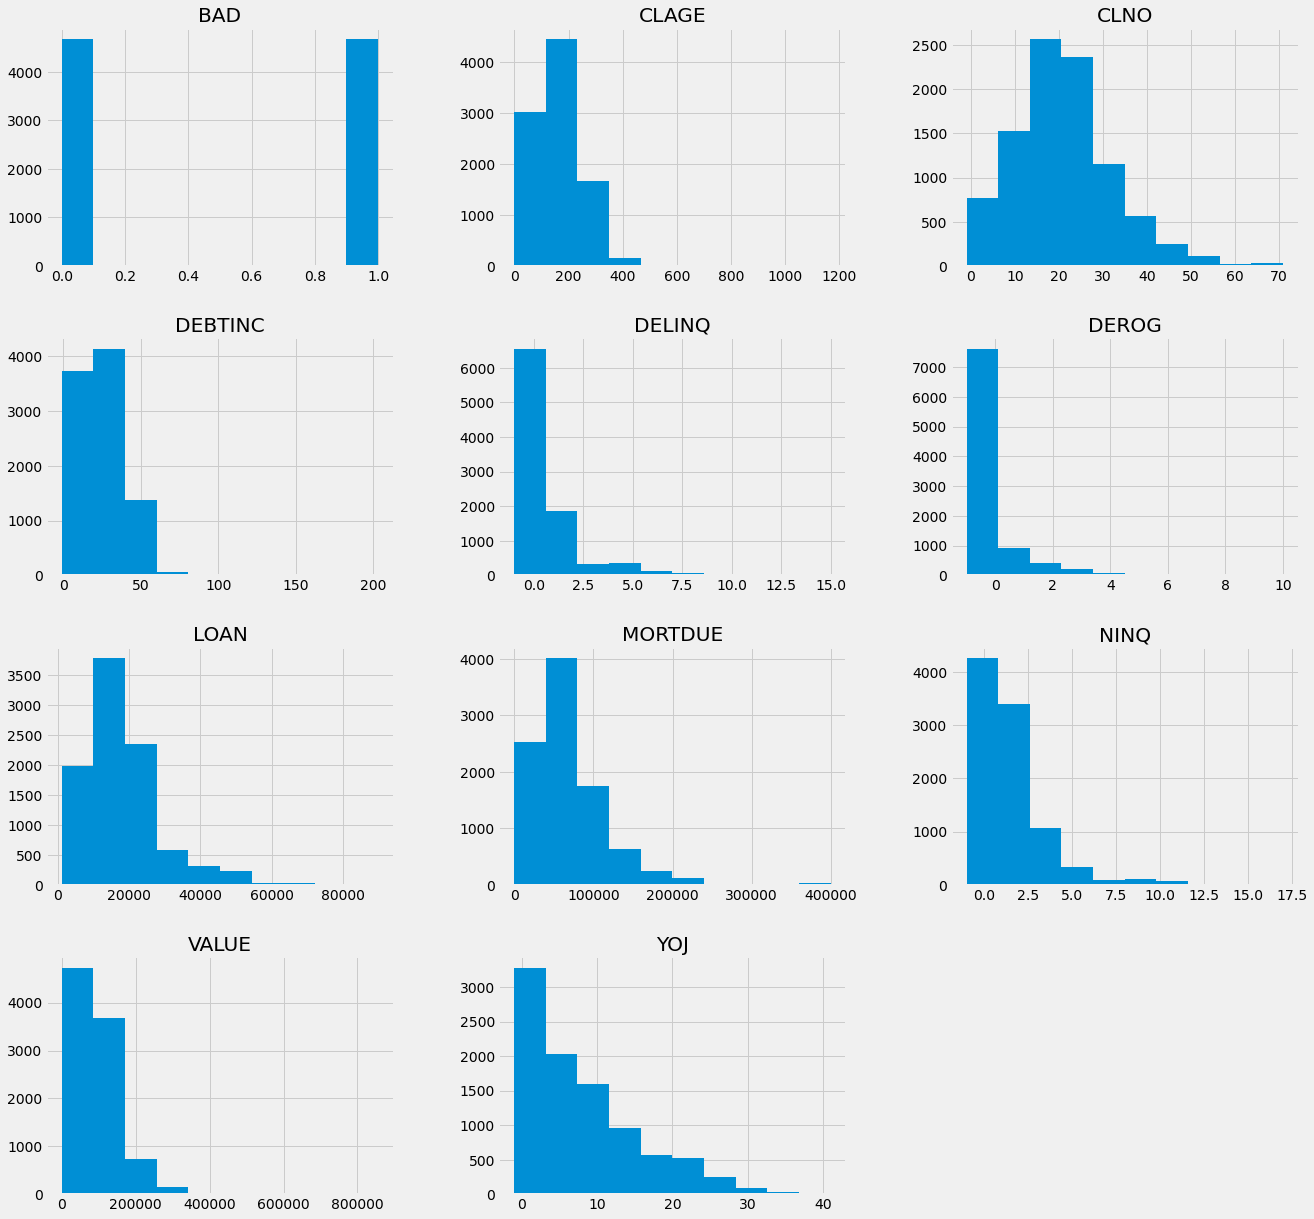

In [11]:
df_upsample.hist(figsize=(20,20))

### 3.4 Dummies
Outra etapa realizada foi a de transoformar as variáveis categóricas em variáveis "Dummy", para que o modelo possa entender os pesos de cada classes dentro das categorias e ser capaz de prever corretamente a resposta.

In [12]:
dummies = ['REASON', 'JOB']
df_upsample = pd.get_dummies(df_upsample, columns=dummies, drop_first=True, dtype='int64')

cols = df_upsample.columns.tolist()
cols = cols[1:] + cols[:1]
df_upsample = df_upsample[cols]
del cols

O dataset ficou, então, com um total de 9.346 observações e 17 colunas após todos os tratamentos realizados.

In [13]:
# =============================================================================
# Observação sobre o dataset rebalanceado
# =============================================================================
df_upsample.info()
df_upsample.describe().T

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9346 entries, 4 to 3114
Data columns (total 17 columns):
LOAN              9346 non-null int64
MORTDUE           9346 non-null float64
VALUE             9346 non-null float64
YOJ               9346 non-null float64
DEROG             9346 non-null float64
DELINQ            9346 non-null float64
CLAGE             9346 non-null float64
NINQ              9346 non-null float64
CLNO              9346 non-null float64
DEBTINC           9346 non-null float64
REASON_HomeImp    9346 non-null int64
JOB_Office        9346 non-null int64
JOB_Other         9346 non-null int64
JOB_ProfExe       9346 non-null int64
JOB_Sales         9346 non-null int64
JOB_Self          9346 non-null int64
BAD               9346 non-null int64
dtypes: float64(9), int64(8)
memory usage: 1.3 MB


,count,mean,std,min,25%,50%,75%,max
LOAN,9346.0,18219.890862,11354.366968,1100.0,10600.000000,15800.000000,23200.000000,89900.000000
MORTDUE,9346.0,67126.349450,48595.140837,-1.0,37094.750000,60271.500000,86785.000000,399550.000000
VALUE,9346.0,96670.596539,66640.499879,-1.0,60500.000000,85000.000000,116967.000000,855909.000000
YOJ,9346.0,7.922812,7.522253,-1.0,2.000000,6.000000,12.000000,41.000000
DEROG,9346.0,0.291890,1.098748,-1.0,0.000000,0.000000,0.000000,10.000000
DELINQ,9346.0,0.650332,1.566684,-1.0,0.000000,0.000000,1.000000,15.000000
CLAGE,9346.0,162.834815,89.368498,-1.0,102.309008,151.195140,215.066667,1168.233561
NINQ,9346.0,1.277552,1.962136,-1.0,0.000000,1.000000,2.000000,17.000000
CLNO,9346.0,20.869998,11.183546,-1.0,14.000000,20.000000,27.000000,71.000000
DEBTINC,9346.0,21.576306,19.668762,-1.0,-1.000000,28.173548,37.311575,203.312149


# 4. Modelo <a name="model"></a>
Para realozação da tarefa de previsão serão utilizados um algorítimo de Random Forest e um de Extra Trees, ambos baseados em modelos de árvore de decisão.
Random Forest consiste em um método que utiliza diversas árvores de decisão durante o treinamento e retorna a média dos resultados individuais dessas árvores, uma grande vantagem desse modelo é a diminuição da possibilidade de overfitting.

Extra trees, de Extremely Randomized Trees ou Árvores Extremamente Aleatóreas, tem como principal diferencial a aleatoriadade dos parâmetros do algorítimo. Esse fator resulta em um modelo com baixa variância e é indicado principalmente para problemas com alta dimensionalidade.

In [14]:
# =============================================================================
# Divisão Treino e Teste
# =============================================================================
train, test = train_test_split(df_upsample, test_size=0.1, random_state=0)
# =============================================================================
# X e Y dos dados de treino
# =============================================================================
X = train.iloc[:,:-1].values
y = train.iloc[:,-1].values
# =============================================================================
# Divisão Treino e Validação
# =============================================================================
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [15]:
# =============================================================================
# Random Forest Classifier
# =============================================================================
''' Scikit-Learn Definition
A random forest is a meta estimator that fits a number of decision tree classifiers 
on various sub-samples of the dataset and uses averaging to improve the predictive 
accuracy and control over-fitting. The sub-sample size is always the same as the 
original input sample size but the samples are drawn with replacement if bootstrap=True (default).
'''
rf = RandomForestClassifier(n_estimators=700, criterion='entropy', random_state=42)

# =============================================================================
# Extra Trees Classifier
# =============================================================================
''' Scikit-Learn Definition
This class implements a meta estimator that fits a number of randomized 
decision trees (a.k.a. extra-trees) on various sub-samples of the dataset 
and uses averaging to improve the predictive accuracy and control over-fitting.
'''
extc = ExtraTreesClassifier(n_estimators=700,
                            criterion='entropy',
                            min_samples_split=5,
                            max_depth=50,
                            min_samples_leaf=5,
                            random_state=42) 

In [16]:
# =============================================================================
# Random Forest
# =============================================================================
rf.fit(X_train, y_train)
y_rfpred = rf.predict(X_test)

# =============================================================================
# Extra Trees
# =============================================================================
extc.fit(X_train, y_train)
y_extcpred = extc.predict(X_test)

In [17]:
# =============================================================================
# Dados de Validação
# =============================================================================
print('Validação Random Forest....Acurácia de: ', "{0:.1f}".format(accuracy_score(y_test, y_rfpred)*100),'%')
print('Validação Extra Trees......Acurácia de: ', "{0:.1f}".format(accuracy_score(y_test, y_extcpred)*100),'%')

# =============================================================================
# Dados de Teste
# =============================================================================
y2_rf = rf.predict(test.iloc[:,:-1].values)
y2_extc = extc.predict(test.iloc[:,:-1].values)
print('\nTeste Random Forest....Acurácia de: ', "{0:.1f}".format(accuracy_score(test.iloc[:,-1].values, y2_rf)*100),'%')
print('Teste Extra Trees......Acurácia de: ', "{0:.1f}".format(accuracy_score(test.iloc[:,-1].values, y2_extc)*100),'%')

Validação Random Forest....Acurácia de:  95.7 %
Validação Extra Trees......Acurácia de:  93.0 %

Teste Random Forest....Acurácia de:  95.9 %
Teste Extra Trees......Acurácia de:  92.7 %


### Validação Cruzada
Para confirmação do desempenho do modelo, iremos utilizar a validação cruzada em 5 agrupamentos de dados aleatórios a fim de verificar o comportamento do mesmo modelo ao lidar com observaçoes diferentes.

In [18]:
scores = cross_val_score(rf, X_train, y_train, n_jobs=-1, cv=5)
print('Scores: ', [round(x,2) for x in scores])
print('Score médio: ', round(scores.mean(),2))

Scores:  [0.96, 0.97, 0.96, 0.97, 0.96]
Score médio:  0.96


In [19]:
scores = cross_val_score(extc, X_train, y_train, n_jobs=-1, cv=5)
print('Scores: ', [round(x,2) for x in scores])
print('Score médio: ', round(scores.mean(),2))

Scores:  [0.92, 0.94, 0.92, 0.93, 0.92]
Score médio:  0.93


### 4.1 Desempenho
O desempenho de ambos os modelos foi muito semelhante e embora, inicialmente, tenha parecido que o modelo Extra Trees havia levado pequena vantagem sobre Random Forest, a validação cruzada mostrou que este fato pode ter ocorrido por uma casualidade da amostra selecionada, visto que em 5 testes aleatórios posteriores o Random Forest se mostrou superior. É interessante também olhar o nível de importância que cada modelo definiu para as variáveis do dataset por meio do gráfico abaixo.

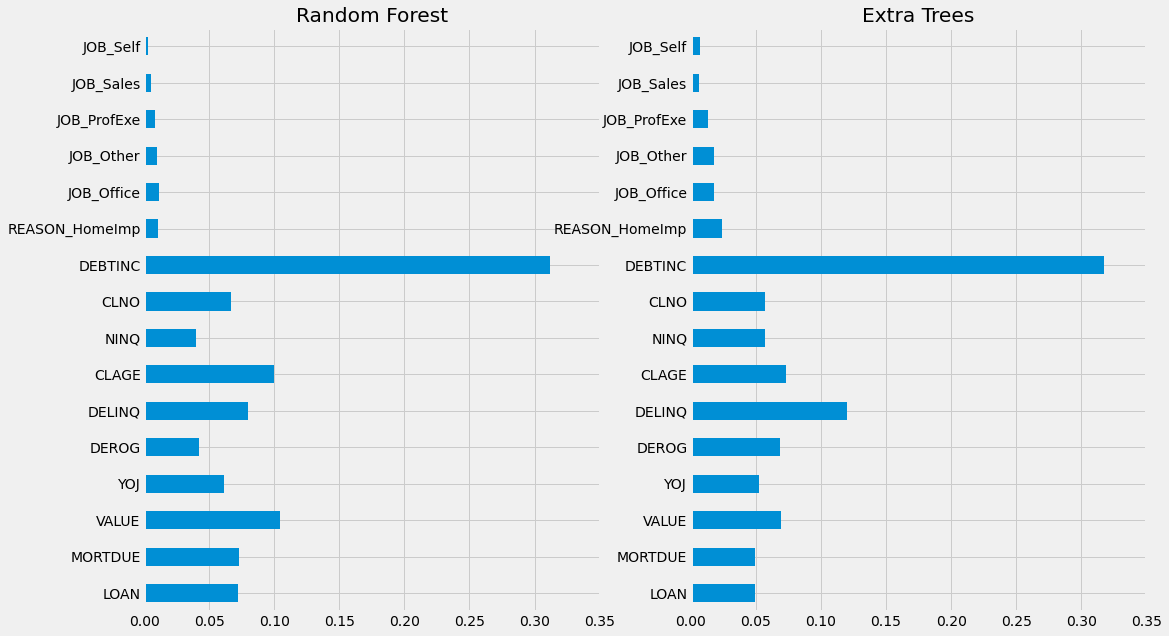

In [20]:
fig, ax = plt.subplots(1,2, figsize=(16,10), sharex=True)
rf_feat_importances = pd.Series(rf.feature_importances_, index=df_upsample.iloc[:,:-1].columns)
ex_feat_importances = pd.Series(extc.feature_importances_, index=df_upsample.iloc[:,:-1].columns)

rf_feat_importances.plot(kind='barh', ax=ax[0], title='Random Forest')
ex_feat_importances.plot(kind='barh', ax=ax[1], title='Extra Trees')

plt.xlim((0.0, 0.35))
plt.show()

Por fim, a Matriz de Confusão nos mostra que o modelo de Random Forest desempenhou de maneira exímia, com altíssimos índices de Sensibilidade e Especificidade.

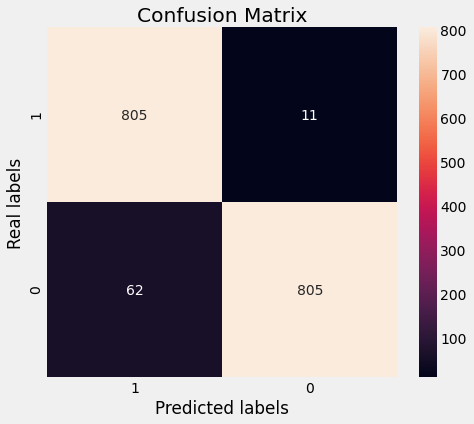

Sensibilidade:  0.93
Especificidade:  0.99


In [21]:
cm = confusion_matrix(y_test, y_rfpred, labels=[1, 0])
'''
default:
[[TN, FP,
  FN, TP]]
  
labels = [1,0]:
[[TP, FP,
  FN, TN]]
'''

fig, ax = plt.subplots(figsize=(7,6))
sns.heatmap(cm, annot=True, ax=ax, fmt='.0f'); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('Real labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['1', '0'])
ax.yaxis.set_ticklabels(['1', '0']);
plt.show()

sens = cm[0,0] / (cm[0,0] + cm[1,0])
esp = cm[1,1] / (cm[0,1] + cm[1,1])

print('Sensibilidade: ', round(sens,2))
print('Especificidade: ', round(esp,2))

# 4. Conclusão <a name="conclusao"></a>

Embora os dados iniciais possuíssem muitos valores missings, o tratamento de dados não apresentou grandes dificuldades e, passada essa etapa, foram bem tranquilas as etapas seguintes de transformação de variáveis dummies e treinamento do modelo. Também foi muito interessante perceber que a aleatoriedade acrescentada pela validação cruzada enriquece bastante a avaliação do melhor modelo, pois a seleção inicial dos dados pode acarretar em um viés escondido. Por fim, o modelo de Random Forest demmonstrou ótimo desempenho, ratificado pela validação cruzada e pela matriz de confusão.